In [75]:
# testing version for Windows (miniconda, astropy310)
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time, TimeDelta, TimezoneInfo
import astropy.units as u

from astroplan import FixedTarget, Observer

from astroplan import (AltitudeConstraint, AirmassConstraint, 
                       AtNightConstraint, TimeConstraint, LocalTimeConstraint, time_grid_from_range, MissingConstraintWarning )
from astroplan import is_observable, is_always_observable, months_observable, observability_table

from datetime import datetime, timezone, timedelta
import datetime as dt
import time
import pytz

import numpy as np

In [76]:
# some functions we need
# Jupyter run these before using the main print_sky function
# this code was cribbed from astroplan's github account, from  a proposed pull request

_current_year = time.localtime().tm_year  # needed for backward compatibility
_current_year_time_range = Time(  # needed for backward compatibility
    [str(_current_year) + '-01-01',
     str(_current_year) + '-12-31'])

def observable_interval(constraints, observer, targets,
                      time_range=_current_year_time_range,
                      time_grid_resolution=0.5*u.hour,
                      interval='months'):
    """
    Determines which weeks the specified ``targets`` are observable for a
    specific ``observer``, given the supplied ``constraints``. Generic version of
    `months_observable` that includes functionality for days and weeks.
    Parameters
    ----------
    constraints : list or `~astroplan.constraints.Constraint`
        Observational constraint(s)
    observer : `~astroplan.Observer`
        The observer who has constraints ``constraints``
    targets : {list, `~astropy.coordinates.SkyCoord`, `~astroplan.FixedTarget`}
        Target or list of targets
    time_range : `~astropy.time.Time` (optional)
        Lower and upper bounds on time sequence
        If ``time_range`` is not specified, defaults to current year (localtime)
    time_grid_resolution : `~astropy.units.Quantity` (optional)
        If ``time_range`` is specified, determine whether constraints are met
        between test times in ``time_range`` by checking constraint at
        linearly-spaced times separated by ``time_resolution``. Default is 0.5
        hours.
        
    interval : str (optional)
        Defines the interval of what dates to calculate ``constraints`` on.
        
    Returns
    -------
    observability : list
        List of sets of unique integers representing each interval that a target is
        observable, one set per target. These integers are 1-based so that
        January maps to 1, Feburary maps to 2, etc., and it is a similar structure
        for day and week intervals.
    """
    # TODO: This method could be sped up a lot by dropping to the trigonometric
    # altitude calculations.
    if not hasattr(constraints, '__len__'):
        constraints = [constraints]
    if interval not in ['days','weeks','months']:
        raise ValueError('interval is of an incorrect type. Please choose days, weeks, or months')

    times = time_grid_from_range(time_range, time_grid_resolution)

    # If the constraints don't include AltitudeConstraint or its subclasses,
    # warn the user that they may get months when the target is below the horizon
    altitude_constraint_supplied = any(
        [isinstance(constraint, AltitudeConstraint) for constraint in constraints]
    )
    if not altitude_constraint_supplied:
        message = ("observable_interval usually expects an AltitudeConstraint or "
                   "AirmassConstraint to ensure targets are above horizon.")
        print(message, MissingConstraintWarning)

    applied_constraints = [constraint(observer, targets,
                                      times=times,
                                      grid_times_targets=True)
                           for constraint in constraints]
    constraint_arr = np.logical_and.reduce(applied_constraints)


    observability = []

    method_dic = {'days':lambda t: t.datetime.timetuple().tm_yday,
                  'weeks':lambda t: t.datetime.isocalendar()[1],
                  'months':lambda t: t.datetime.month}


    for target, observable in zip(targets, constraint_arr):
        s = set([method_dic[interval](t) for t in times[observable]]) # type: ignore
        observability.append(s)

    return observability


# more routines - to help load database of objects
# db is in json shaped like this:
    # {
    #     "dso_id": 2,
    #     "catalog": "M 45",
    #     "name": "Pleiades M45",
    #     "ra_dd": 56.75,
    #     "dec_dd": 24.117,
    #     "type": "C+N",
    #     "vis_mag": 1.2,
    #     "maj_axis": 110.0,
    #     "min_axis": 110.0,
    #     "search_name": "Pleiades M45 M 45 3h"
    # }

def load_dso_db(file_path):
    import json
    with open(file_path, 'r') as f:
        dso_db = json.load(f)
    return dso_db

# target cat numbers are the catalog numbers of the targets we want to observe
# dos field has a space like "M 45"
def get_targets_from_db(dso_db, target_cat_numbers: list):
    targets = []
    for dso in dso_db:
        if dso['catalog'] in target_cat_numbers:
            targets.append(FixedTarget(coord=SkyCoord(ra=dso['ra_dd']*u.deg, dec=dso['dec_dd']*u.deg), name=dso['name']))
    return targets

def convert_local_time_to_utc_time(hhmm:str, local_tz: str):
    naive_hour, naive_min = hhmm.split(':')
    # Create a naive datetime object for desired hour, min
    naive_time = datetime(datetime.now().year, datetime.now().month, datetime.now().day,
                           int(naive_hour), int(naive_min), 0)

    # Localize the naive datetime object to desired timezone
    local_tzone = pytz.timezone(local_tz) # e.g., 'US/Central'
    local_time = local_tzone.localize(naive_time)

    # Convert the local time to UTC
    utc_time = local_time.astimezone(pytz.UTC)
    
    # return the UTC time component
    return(utc_time.time())


# not currently used
def convert_date_to_fractional_week(dt: datetime):
    """Converts a date to a fractional week.
    The fractional week is the number of weeks since the start of the year
    plus the fraction of the week that has passed. The start of the week is
    defined by the observer's timezone.
    """
    # Get the start of the week in the observer's timezone
    start_of_week = dt - dt.weekday() * timedelta(days=1)
    start_of_week = start_of_week.replace(hour=0, minute=0, second=0, microsecond=0)
    # Get the number of days since the start of the week
    days_since_start_of_week = (dt - start_of_week).total_seconds() / (24 * 3600)
    # Get the fractional week
    fractional_week = start_of_week.isocalendar()[1] + days_since_start_of_week / 7
    return fractional_week


In [77]:
# experiments to determine visibility of planets, to match the dso targets
# inputs - one planet
# observer location
# minimum altitude (max is 90)
# hours of observation, in local time (eg 20:00, 23:59)
# the year to scan (string YYYY)
# output - list of the days of the year when this planet is visible.  Jan 1 = day # 1

"""
    results = []
    for each day_num in year (1, 2, ... 365)
        for each 30 minute interval from start to stop hour
            calc local time as start + interval
            convert to utc
            create Time object
            calculate altaz at that utc Time and for Observer
            if alt > min_alt:
                push day_num into results
    return results
"""
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_body, solar_system_ephemeris
from astropy.time import Time, TimeDelta, TimezoneInfo
import astropy.units as u
from astroplan import FixedTarget, Observer
from astroplan import (AltitudeConstraint, AirmassConstraint, 
                       AtNightConstraint, TimeConstraint, LocalTimeConstraint, time_grid_from_range, MissingConstraintWarning )
from astroplan import is_observable, is_always_observable, months_observable, observability_table
import datetime
import pytz
import numpy as np

# define our observatory (Powell Observatory)
powell = Observer(latitude=38.64633*u.deg, longitude=-94.699973*u.deg,
                   elevation=300*u.m, name="Powell Observatory", timezone="US/Central")

name = 'Jupiter'
local_tzone = pytz.timezone("US/Central")
local_time = datetime.datetime.now() #"2024-03-01 03:42:00"
# local_time = local_time + datetime.timedelta(minutes=30)
local_time_loc = local_tzone.localize(local_time)
utc_time = local_time.astimezone(pytz.UTC)

#local_time = local_tzone.localize(naive_time)

    # Convert the local time to UTC
astropy_time = Time(utc_time)
print("local time = ", local_time)
print("localized local = ", local_time_loc)
print("utc time = ", utc_time)
print("astropy time = ", astropy_time)

with solar_system_ephemeris.set('builtin'):
    # get skycoord - uses GCRS frame
    planet_skycoord = get_body(name, astropy_time, powell.location)
    print("sky coord", planet_skycoord)

# this also GCRS
sky_coord_2 = get_body(name, astropy_time, powell.location)
print("sky coord 2", sky_coord_2)

alt_az_frame = AltAz(obstime=astropy_time, location=powell.location)
planet_altaz = planet_skycoord.transform_to(alt_az_frame)

# this is local altaz frame!
print("planet alt_az", planet_altaz, " degree ", planet_altaz.alt.degree)

sky_coord_3 =get_body(name, astropy_time, powell.location)
print("sky coord 3", sky_coord_3)

altaz_frame_1 = AltAz(obstime=astropy_time, location=powell.location)
transformed = sky_coord_3.transform_to(altaz_frame_1)
print(f"AA frame 1: {transformed.alt.degree:.2f}, Azimuth: {transformed.az.degree:.2f}")

astropy_time_2 = astropy_time + TimeDelta(30*u.minute)
altaz_frame_2 = AltAz(obstime=astropy_time_2, location=powell.location)
transformed_2 = sky_coord_3.transform_to(altaz_frame_2)
print(f"AA frame 2: {transformed_2.alt.degree:.2f}, Azimuth: {transformed_2.az.degree:.2f}")

from datetime import datetime as dt
naive_time = dt(dt.now().year, dt.now().month, dt.now().day,
                           int(9), int(0), 0)

# Localize the naive datetime object to desired timezone
local_tzone = pytz.timezone("US/Central") # e.g., 'US/Central'
local_time = local_tzone.localize(naive_time)

# Convert the local time to UTC
utc_time = local_time.astimezone(pytz.UTC)

astropy_time = Time.now() #Time('2024-03-13T00:00:00', format='isot', scale='utc')
sk =get_body("jupiter", astropy_time, powell.location)

print("starting astropy time = ", astropy_time)

center_time = dt(2024, 3, 13, 22, 20, 0)
center_utc = center_time.astimezone(pytz.UTC)
center_astropy = Time(center_utc)
print("center time = ", center_time)
print("center utc = ", center_utc)
print("center astropy = ", center_astropy)

def test_planet_loc(astropy_time):
    local_tzone = pytz.timezone("US/Central") # e.g., 'US/Central'
    
    # don't repeat this each time
    sk =get_body("jupiter", astropy_time, location= powell.location)

    for i in range(-50, 50):
        
        astropy_time_2 = astropy_time + TimeDelta(i*u.hour)
        
        # Convert astropyTime to Python datetime object in UTC
        py_time_utc = astropy_time_2.to_datetime(timezone=pytz.UTC)
        
        # then localize to local timezone
        local_time_2 = py_time_utc.astimezone(local_tzone)
        
        altaz_frame_2 = AltAz(obstime=astropy_time_2, location=powell.location)
        transformed_2 = sk.transform_to(altaz_frame_2)
        print(f"AA frame at {astropy_time_2} is {local_time_2}: {transformed_2.alt.degree:.2f}, Azimuth: {transformed_2.az.degree:.2f}")

def planet_by_days_and_time(start_time):
    sk =get_body("jupiter", Time.now(), powell.location)
    for i in range(1, 366):
        for hour in np.arange(20, 24, 0.5):
            # create our local time
            local_time = start_time + timedelta(days=i, hours=hour)
            # convert to UTC
            utc_time = local_time.astimezone(pytz.UTC)
            # create astropy time object
            astropy_time = Time(utc_time)
            # get the planet's location
            
            # convert to altaz
            altaz_frame = AltAz(obstime=astropy_time, location=powell.location)
            transformed = sk.transform_to(altaz_frame)
            print(f"AA frame at {astropy_time} is {local_time}: {transformed.alt.degree:.2f}, Azimuth: {transformed.az.degree:.2f}")
            
t = Time('2024-03-13T00:00:00', format='isot', scale='utc')
t

local time =  2024-03-15 23:29:16.084808
localized local =  2024-03-15 23:29:16.084808-05:00
utc time =  2024-03-16 04:29:16.084808+00:00
astropy time =  2024-03-16 04:29:16.084808
sky coord <SkyCoord (GCRS: obstime=2024-03-16 04:29:16.084808, obsgeoloc=(-4153502.41686375, 2748417.11812585, 3971560.92551198) m, obsgeovel=(-200.40611023, -303.55590158, 0.48116421) m / s): (ra, dec, distance) in (deg, deg, AU)
    (41.58113393, 15.14538787, 5.61062141)>
sky coord 2 <SkyCoord (GCRS: obstime=2024-03-16 04:29:16.084808, obsgeoloc=(-4153502.41686375, 2748417.11812585, 3971560.92551198) m, obsgeovel=(-200.40611023, -303.55590158, 0.48116421) m / s): (ra, dec, distance) in (deg, deg, AU)
    (41.58113393, 15.14538787, 5.61062141)>
planet alt_az <SkyCoord (AltAz: obstime=2024-03-16 04:29:16.084808, location=(-408721.31653067, -4971402.36351492, 3961916.27783899) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, AU)
    (291.1

<Time object: scale='utc' format='isot' value=2024-03-13T00:00:00.000>

In [22]:
import pendulum
now = pendulum.now()
print(now)
print(now.timezone_name)
print(now.in_tz('US/Central'))
print(now.in_tz('UTC'))

# first = pendulum.datetime(2024, 1, 1, 20, 0,  0, tz='US/Central').in_tz('UTC')
# last = pendulum.datetime(2024, 1, 1,  23, 59, 0, tz='US/Central').in_tz('UTC')
# # # added = first + timedelta(hours = .5)
# print("hors ",first, last, added)

# start_time = "20:00" # LOCAL 8:00pm
# end_time = "23:59"   # LOCAL 11:59pm
# start_hours_utc =  convert_local_time_to_utc_time(start_time, 'US/Central')
# end_hours_utc = convert_local_time_to_utc_time(end_time, 'US/Central')
# print("start hours utc = ", start_hours_utc)
# print("end hours utc = ", end_hours_utc)

#t = Time(['2024-03-13T00:00:00', '2024-04-13T00:00:00', '2024-05-13T00:00:00'], format='isot', scale='utc')
jan1 = Time('2024-01-01T00:00:00', format='isot', scale='utc')
#times = [jan1.jd + i for i in range(1, 365)]


times = []
for i in range(0, 365):
    dt = pendulum.datetime(2024, 1, 1, 0, 0,  0, tz='US/Central').in_tz('UTC')
    dt = dt.add(days=i) # step day to day
    dt = dt.add(hours=20) # starting time 8PM
    for steps in range(8): # 8 steps of 30 minutes: 8, 830, 9, 930, 10, 1030, 11, 1130
        # print("dt = ", dt.to_datetime_string())
        times.append( dt )
        dt = dt.add(minutes=30)

# format='datetime' takes the actual datetime object, rather than a string!
t= Time(times, format='datetime', scale='utc')

sk =get_body("jupiter", Time.now(), location= powell.location)
print(sk)

# the frames can be an array, but the SkyCoord object can only be one object
altaz_frame = AltAz(obstime=t, location=powell.location)
# print(altaz_frame)
transformed = sk.transform_to(altaz_frame)
for i in range(len(transformed)):
    utc_py_time = t[i].to_datetime(timezone=pytz.UTC)
    local_tzone = pytz.timezone("US/Central") # e.g., 'US/Central'
    local_time = utc_py_time.astimezone(local_tzone)
    print(f"AA frame at {t[i].iso}: local:{local_time} {transformed[i].alt.degree:.2f}, Azimuth: {transformed[i].az.degree:.2f}")

2024-03-15 16:50:07.384599-05:00
America/Chicago
2024-03-15 16:50:07.384599-05:00
2024-03-15 21:50:07.384599+00:00
<SkyCoord (GCRS: obstime=2024-03-15 21:50:07.444502, obsgeoloc=(3442388.40430997, 3618929.47981632, 3953730.7269391) m, obsgeovel=(-263.88473821, 250.34676159, 0.60866239) m / s): (ra, dec, distance) in (deg, deg, AU)
    (41.52825263, 15.12856289, 5.60722203)>
AA frame at 2024-01-02 02:00:00.000: local:2024-01-01 20:00:00-06:00 65.73, Azimuth: 169.74
AA frame at 2024-01-02 02:30:00.000: local:2024-01-01 20:30:00-06:00 65.87, Azimuth: 187.55
AA frame at 2024-01-02 03:00:00.000: local:2024-01-01 21:00:00-06:00 64.24, Azimuth: 204.43
AA frame at 2024-01-02 03:30:00.000: local:2024-01-01 21:30:00-06:00 61.15, Azimuth: 218.84
AA frame at 2024-01-02 04:00:00.000: local:2024-01-01 22:00:00-06:00 57.01, Azimuth: 230.52
AA frame at 2024-01-02 04:30:00.000: local:2024-01-01 22:30:00-06:00 52.18, Azimuth: 239.94
AA frame at 2024-01-02 05:00:00.000: local:2024-01-01 23:00:00-06:00 46

In [78]:
import pendulum, pytz
from datetime import datetime
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_body, solar_system_ephemeris
from astropy.time import Time, TimeDelta, TimezoneInfo
import astropy.units as u

def setup_times(start_date, start_hour_local:int, end_hour_local:int, step_time_mins:int=30):
    # create an Astropy Time object covering a year's worth of observation samples
    # sample between start_hour_local (eg 20) and end_hour_local (eg 24)
    # local times will be converted to UTC for astropy functions to use
    # start_date is a python datetime object
    # times can be reused for additional planets
    
    times = []
    start = pendulum.datetime(start_date.year, start_date.month, start_date.day, 0, 0,  0, tz='US/Central').in_tz('UTC')
    for i in range(0, 365):
        day = start.add(days=i) # adjust start date to the day we want
        dt = day.add(hours=start_hour_local) # jump to starting time
        # step until we exceed the end time
        stop = day.add(hours=end_hour_local)
        # print("day = ", day.to_datetime_string(), "start = ", dt.to_datetime_string(), "stop = ", stop.to_datetime_string())
        while dt < stop:
            times.append( dt )
            # print("dt = ", dt.to_datetime_string(), dt.hour)
            dt = dt.add(minutes=step_time_mins)

    # format='datetime' takes the actual datetime object, rather than a string!
    t= Time(times, format='datetime', scale='utc')
    return t    

def sample_planet_visibility(planet_name:str, sample_times:Time, observer:Observer):
    # get the planet's locations against the sample times
    sk =get_body(planet_name, sample_times, observer.location)
    # get altaz frames for times and location
    altaz_frames = AltAz(obstime=sample_times, location=observer.location)
    # transform the SKs to the altaz frames
    transformed = sk.transform_to(altaz_frames)
    return transformed

local_tzone = pytz.timezone("US/Central") # e.g., 'US/Central'

# define our observatory (Powell Observatory)
powell = Observer(latitude=38.64633*u.deg, longitude=-94.699973*u.deg,
                   elevation=300*u.m, name="Powell Observatory", timezone="US/Central")

t = setup_times(pendulum.datetime(2024, 1, 1, 0, 0,  0, tz='US/Central'), 20, 24, 30)
# for i in range(len(t)):
#     utc_py_time = t[i].to_datetime(timezone=pytz.UTC)
#     local_time = utc_py_time.astimezone(local_tzone)
#     print(t[i].iso, local_time )

altaz = sample_planet_visibility("uranus", t, powell)
# print(altaz)

for i in range(len(altaz)):
    utc_py_time = t[i].to_datetime(timezone=pytz.UTC)
    local_time = utc_py_time.astimezone(local_tzone)
    print(f"AA frame at {t[i].iso}: local:{local_time} Alt: {altaz[i].alt.degree:.2f}, Azimuth: {altaz[i].az.degree:.2f}")


AA frame at 2024-01-02 02:00:00.000: local:2024-01-01 20:00:00-06:00 Alt: 66.75, Azimuth: 153.91
AA frame at 2024-01-02 02:30:00.000: local:2024-01-01 20:30:00-06:00 Alt: 68.47, Azimuth: 172.29
AA frame at 2024-01-02 03:00:00.000: local:2024-01-01 21:00:00-06:00 Alt: 68.26, Azimuth: 191.84
AA frame at 2024-01-02 03:30:00.000: local:2024-01-01 21:30:00-06:00 Alt: 66.16, Azimuth: 209.65
AA frame at 2024-01-02 04:00:00.000: local:2024-01-01 22:00:00-06:00 Alt: 62.62, Azimuth: 224.17
AA frame at 2024-01-02 04:30:00.000: local:2024-01-01 22:30:00-06:00 Alt: 58.12, Azimuth: 235.54
AA frame at 2024-01-02 05:00:00.000: local:2024-01-01 23:00:00-06:00 Alt: 53.03, Azimuth: 244.52
AA frame at 2024-01-02 05:30:00.000: local:2024-01-01 23:30:00-06:00 Alt: 47.58, Azimuth: 251.86
AA frame at 2024-01-03 02:00:00.000: local:2024-01-02 20:00:00-06:00 Alt: 67.08, Azimuth: 156.21
AA frame at 2024-01-03 02:30:00.000: local:2024-01-02 20:30:00-06:00 Alt: 68.55, Azimuth: 174.91
AA frame at 2024-01-03 03:00:0

In [70]:
# can we use sunset time instead of sample times?

# get the sunset time for the observer
sunset = powell.sun_set_time(Time.now(), which='next', horizon=-12*u.deg) # -6 = civil twilight, -12 = nautical, -18 = astronomical
local_sunset = sunset.to_datetime(local_tzone)
print(sunset, local_sunset)

def object_elevation_at_onset_dark(planet_name:str, observer:Observer, obs_date:Time, horizon:float) -> float:
    # get the planet's elevation at , using horizon angle as the cutoff
    # horizon: -6 = civil twilight, -12 = nautical, -18 = astronomical
    sunset = observer.sun_set_time(obs_date, which='next', horizon=horizon*u.deg) 
    sk =get_body(planet_name, sunset, observer.location)
    # get altaz frame for sunset and location
    altaz_frame = AltAz(obstime=sunset, location=observer.location)
    # transform the SK to the altaz frame
    transformed = sk.transform_to(altaz_frame)
    # local_time = sunset.to_datetime(timezone=pytz.utc).astimezone(local_tzone)
    # print(f"AA frame at {sunset.iso}: Local: {local_time} Alt: {transformed.alt.degree:.2f}, Azimuth: {transformed.az.degree:.2f}")
    return float(transformed.alt.degree)

def setup_onset_dark_times(start_date, horizon):
    # create an Astropy Time object covering a year's worth of observation samples
    # sample time is onset of darkness, defined as the time the sun sets below the horizon elevation
    
    times = []
    start = pendulum.datetime(start_date.year, start_date.month, start_date.day, 0, 0,  0, tz='US/Central').in_tz('UTC')
    for i in range(0, 365):
        day = start.add(days=i) # adjust start date to the day we want
        sunset = powell.sun_set_time(Time(day), which='next', horizon=horizon*u.deg)
        times.append(sunset.iso)
    return Time(times)

def sample_planet_visibility(planet_name:str, sample_times:Time, observer:Observer):
    # get the planet's locations against the sample times
    sk =get_body(planet_name, sample_times, observer.location)
    # get altaz frames for times and location
    altaz_frames = AltAz(obstime=sample_times, location=observer.location)
    # transform the SKs to the altaz frames
    transformed = sk.transform_to(altaz_frames)
    return transformed

obs_date = pendulum.datetime(2024, 3, 15, 0, 0, 0, tz='US/Central')
object_elevation_at_onset_dark("moon", powell, Time(obs_date), -12)

# try every day of the year
# this is slow - let's use Time array
# for i in range(1, 366):
#     obs_date = pendulum.datetime(2024, 1, 1, 0, 0, 0, tz='US/Central').add(days=i)
#     ele = object_elevation_at_onset_dark("jupiter", powell, Time(obs_date), -12)
#     print(f"day {i} elevation = {ele:.2f}")

t = setup_onset_dark_times(pendulum.datetime(2024, 1, 1, 0, 0, 0, tz='US/Central'), -12)
# print("t done, length = ", len(t)) 

tr = sample_planet_visibility("moon", t, powell)
# print("tr done, length = ", len(tr))

for i in range(len(tr)):
    utc_py_time = t[i].to_datetime(timezone=pytz.UTC)
    local_time = utc_py_time.astimezone(local_tzone)
    print(f"AA frame at {t[i].iso}: local:{local_time} Alt: {tr[i].alt.degree:.2f}, Azimuth: {tr[i].az.degree:.2f}")


2460386.558929266 2024-03-16 20:24:51.488577-05:00
tr done, length =  365
AA frame at 2024-01-02 00:10:53.782: local:2024-01-01 18:10:53.782000-06:00 Alt: -41.36, Azimuth: 25.49
AA frame at 2024-01-03 00:11:39.409: local:2024-01-02 18:11:39.409000-06:00 Alt: -49.13, Azimuth: 15.01
AA frame at 2024-01-04 00:12:26.037: local:2024-01-03 18:12:26.037000-06:00 Alt: -55.69, Azimuth: 0.94
AA frame at 2024-01-05 00:13:13.581: local:2024-01-04 18:13:13.581000-06:00 Alt: -60.10, Azimuth: 342.02
AA frame at 2024-01-06 00:14:02.219: local:2024-01-05 18:14:02.219000-06:00 Alt: -61.11, Azimuth: 319.24
AA frame at 2024-01-07 00:14:51.910: local:2024-01-06 18:14:51.910000-06:00 Alt: -58.08, Azimuth: 297.20
AA frame at 2024-01-08 00:15:42.613: local:2024-01-07 18:15:42.613000-06:00 Alt: -51.63, Azimuth: 279.75
AA frame at 2024-01-09 00:16:34.282: local:2024-01-08 18:16:34.282000-06:00 Alt: -42.82, Azimuth: 267.01
AA frame at 2024-01-10 00:17:26.874: local:2024-01-09 18:17:26.874000-06:00 Alt: -32.47, A

In [80]:
# plotting code,  with help from GPT
# Jupyter run these before using the main print_sky function

import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.ticker import MultipleLocator
import numpy as np

# this code doesn't work, but I don't need it right now
def get_text_width(fig, ax, text, fontsize):
    # r = fig.canvas.get_renderer()
    # t = ax.text(0,0,text, fontsize=fontsize)

    # get text bounding box in figure coordinates
    renderer = fig.canvas.get_renderer()
    bbox_text = text.get_window_extent(renderer=renderer)

    # transform bounding box to data coordinates
    bbox_text = Bbox(ax.transData.inverted().transform(bbox_text))

    # bb = t.get_window_extent(renderer=r).inverse_transformed(ax.transData)
    # bb = t.get_window_extent(renderer=r).transformed(ax.transData.inverted())
    width = bbox_text.width
    height = bbox_text.height
    return width    

def do_a_print(observer, targets, obs_interval, hours, min_ele, 
                target_class, public_nights, print_file_path=None):
    
    num_dso = len(targets)
    num_intervals = 365

    data = np.zeros((num_dso, num_intervals))

    for i in range(num_dso):
        
        # intervals will be [day#, day#, day#, ...] with 1 for visible and 0 for not visible
        # day 1 is Jan 1, day 365 is Dec 31
        for interval in obs_interval[i]:
            data[i, interval-1] = 1  # so data[0,0] is Jan 1, data[0,364] is Dec 31

    fig, ax = plt.subplots(figsize=(8.5,11))  # Landscape orientation
    # fig_off, ax_off = plt.subplots(figsize=(11, 8.5))  # Landscape orientation

    y_lim = len(targets)
    
    ax.invert_yaxis()
    ax.set_xlim(0, 365)
    ax.set_ylim(-1, y_lim)

    for i, row in enumerate(data):
        for j, visible in enumerate(row): # across the days in this row (this dso)
            if visible:
                if j == 0 or not row[j-1]:
                    start = j
                if j == len(row)-1 or not row[j+1]:
                    end = j
                    ax.plot([start, end], [i, i], 'b', lw=2)
                    if end - start > 10:
                        # print(f"{targets[i].name} = {get_text_width(fig,ax,{targets[i].name}, 9)}")
                        if start <= 1:
                            start = 2
                            ax.text(start, i, 
                                targets[i].name, color='purple', fontsize=9, ha='left', va='bottom')
                        elif end >= 362:
                            end = 362
                            ax.text(end, i, 
                                targets[i].name, color='purple', fontsize=9, ha='right', va='bottom')
                        else:
                            ax.text(start + (end - start)/2, i, 
                                targets[i].name, color='purple', fontsize=9, ha='center', va='bottom')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    # month_weeks = np.arange(0, 51, 4.33)
    month_days = [datetime(2024,m,1).timetuple().tm_yday for m in range(1,13)]

    ax.set_yticks([])
    # ax.set_yticklabels([f'{targets[i].name}' for i in range(num_dso)])
    ax.set_xticks(month_days)
    ax.set_xticklabels(months)
    ax.set_xlabel('Date')
    # ax.set_ylabel('Targets for Ruisinger Imaging')
    ax.set_title(
        f"""Visibility of {target_class} at {observer.name}
        Obs. Hours: {hours}  Min Elevation: {min_ele} degrees
        """)
                
    for pn in public_nights:
        # plt.axvline(x=special_mark, y=1, color='red', linewidth=0.5)
        x_val = pn.timetuple().tm_yday
        plt.plot([x_val, x_val], [y_lim-.4, y_lim], color='blue', linewidth=0.5)

    # Adding minor ticks for weeks
    # ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True, which='major', axis='x', linestyle=':', linewidth=0.8)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()
    if print_file_path:
        fig.savefig(print_file_path, format='jpg', dpi=300)

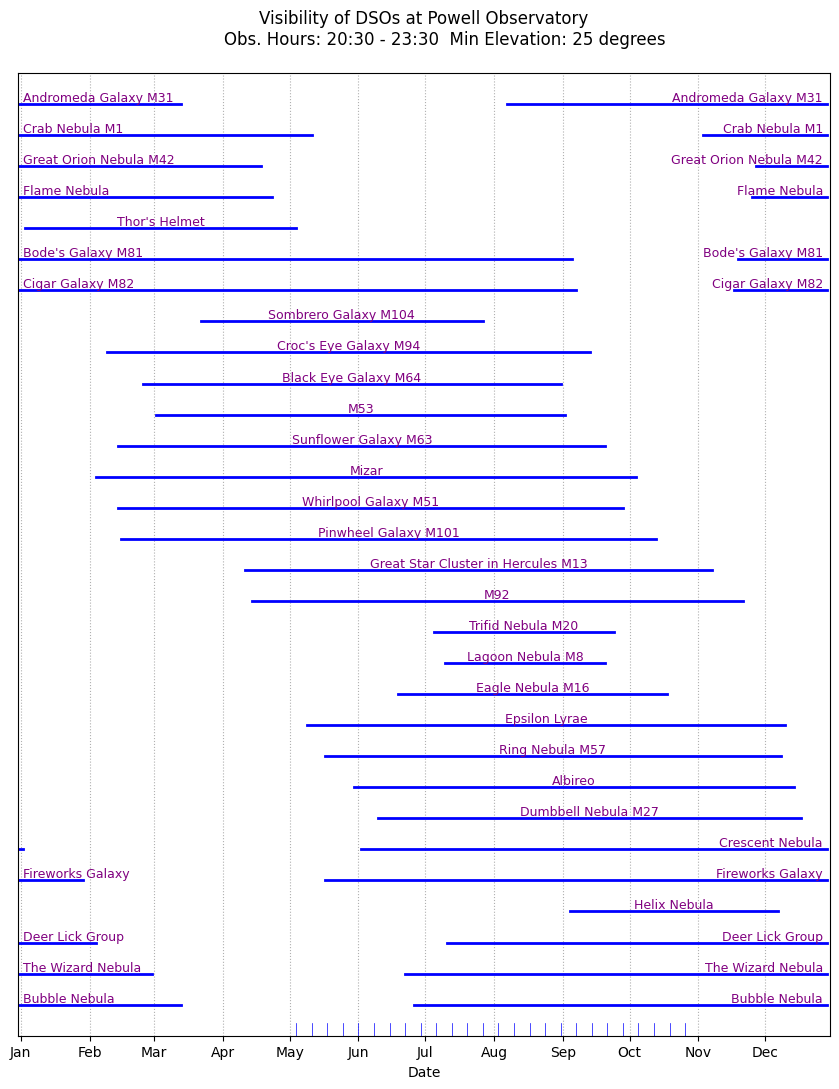

In [81]:
# RUN the program from here, after first running the above sections to set things up.
import datetime as dt
public_nights = [dt.datetime(2024,5,4), dt.datetime(2024, 5,11), dt.datetime(2024, 5,18),
                    dt.datetime(2024, 5,25), dt.datetime(2024, 6,1), dt.datetime(2024, 6,8),
                    dt.datetime(2024, 6,15), dt.datetime(2024, 6,22), dt.datetime(2024, 6,29),
                    dt.datetime(2024, 7,6), dt.datetime(2024, 7,13), dt.datetime(2024, 7,20),
                    dt.datetime(2024, 7,27), dt.datetime(2024, 8,3), dt.datetime(2024, 8,10),
                    dt.datetime(2024, 8,17), dt.datetime(2024, 8,24), dt.datetime(2024, 8,31),
                    dt.datetime(2024, 9,7), dt.datetime(2024, 9,14), dt.datetime(2024, 9,21),
                    dt.datetime(2024, 9,28), dt.datetime(2024, 10,5), dt.datetime(2024, 10,12),
                    dt.datetime(2024, 10,19), dt.datetime(2024, 10,26)]

# define our observatory (Powell Observatory)
powell = Observer(latitude=38.64633*u.deg, longitude=-94.699973*u.deg,
                   elevation=300*u.m, name="Powell Observatory", timezone="US/Central")

# define targets

ruisinger_nebula = ['M 1', 'M 8', 'M 16',  'M 13', 'M 16', 'M 20', 'M 27', 'M 31', 'M 42', 'M 51', 
                    'M 53', 'M 57', 'M 63', 'M 64', 'M 81', 'M 82', 'M 92', 'M 94', 'M 101', 'M 104', 
                    'NGC 7293', 'NGC 7320', 'NGC 7635', 'NGC 6888', 'NGC 6946', 'NGC 7331', 
                    'NGC 2359', 'NGC 2023', 'NGC 2024', 'NGC 7380',
                    'SH2 279', 'Albireo', 'Mizar', 'Epsilon Lyrae'  ]
# read in targets
db_path = 'sky_database.json'
dso_db = load_dso_db(db_path)

targets = get_targets_from_db(dso_db, ruisinger_nebula)

# sort targets in ra order
targets.sort(key=lambda x: x.ra.hour)

# define constraints
min_altitude = 25*u.deg
max_airmass = 3
start_time = "20:30" # LOCAL 8:30pm
end_time = "23:30"   # LOCAL 11:30pm
start_hours_utc =  convert_local_time_to_utc_time(start_time, 'US/Central')
end_hours_utc = convert_local_time_to_utc_time(end_time, 'US/Central')

# looks like local constraints ONLY work with hours at UTC location!!
constraints = [  AltitudeConstraint(25*u.deg, 90*u.deg),\
                 # AirmassConstraint(3),
                 LocalTimeConstraint(min=start_hours_utc, max=end_hours_utc)]

# call observable_interval to calculate the visibility
obs_interval = observable_interval(constraints, powell, targets,
            time_grid_resolution=0.5*u.hour, interval='days')
# for i, obs in enumerate(obs_interval):
#     print(targets[i].name, obs)

# call do_a_print to plot the results
do_a_print(observer=powell, targets=targets, obs_interval=obs_interval, 
           hours=f"{start_time} - {end_time}", min_ele=25, target_class="DSOs",
            public_nights=public_nights, print_file_path='dso_visibility.jpg')